# Violação das Suposições do Modelos

Ao usar uma regressão para ajustar um modelo a dados, os pressupostos da análise de regressão devem ser satisfeitos para garantir boas estimativas de parâmetros e estatísticas de ajuste precisas. Nós gostaríamos que os parâmetros fossem:
* imparcial (o valor esperado em diferentes amostras é o valor verdadeiro)
* consistente (convergente para o valor verdadeiro com muitas amostras) e
* eficiente (variância minimizada)

Abaixo investigamos as formas em que esses pressupostos podem ser violados e o efeito sobre os parâmetros e as estatísticas de ajuste. Usaremos regressões lineares de variável única para os exemplos, mas as mesmas considerações se aplicam a outros modelos. Também assumiremos que nosso modelo está corretamente especificado; ou seja, que a forma funcional que escolhemos é válida. Discutimos erros de especificação do modelo, juntamente com as violações da suposição e outros problemas que elas causam em outro notebook.

# Foco nos Residuais

Ao invés de se concentrar na construção do seu modelo, é possível obter uma grande quantidade de informações de seus resíduos (erros). Seu modelo pode ser incrivelmente complexo e impossível de analisar, mas desde que você tenha previsões e valores observados, você pode calcular os resíduos. Uma vez que você tenha seus resíduos, você pode realizar muitos testes estatísticos.

Se os seus resíduos não seguem uma dada distribuição (geralmente normal, mas depende do seu modelo), então você sabe que algo está errado e você deve se preocupar com a precisão de suas previsões.

# Residuais normalmente não distribuídos

Se o termo de erro não for normalmente distribuído, nossos testes de significância estatística darão respostas erroneas. Felizmente, o teorema do limite central nos diz que, para amostras de dados suficientemente grandes, as distribuições de coeficientes serão próximas a normal, mesmo que os erros não sejam. Portanto, nossa análise ainda será válida para grandes conjuntos de dados.

## Testando a normalidade

Uma boa prova de normalidade é o teste de Jarque-Bera. Tem uma implementação do python em `statsmodels.stats.stattools.jarque_bera`, usaremos com freqüência neste notebook.

### Teste sempre a normalidade!

É incrivelmente fácil e pode poupar um bom tempo.

In [1]:
# Import all the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression, stats
import statsmodels
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline

/home/tau/Projects/ds_intro/venv/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
"""Jarque-Bera"""
residuals = np.random.normal(0, 1, 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print(pvalue)

residuals = np.random.poisson(size = 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print(pvalue)

0.8416324838254255
1.565720410371354e-07


# Heterosqueticidade

Heterosqueticidade significa que a variância dos termos de erro não é constante em todas as observações. Intuitivamente, isso significa que as observações não estão uniformemente distribuídas ao longo da linha de regressão. Muitas vezes ocorre em dados transversais onde as diferenças nas amostras que estamos medindo levam a diferenças na variância.

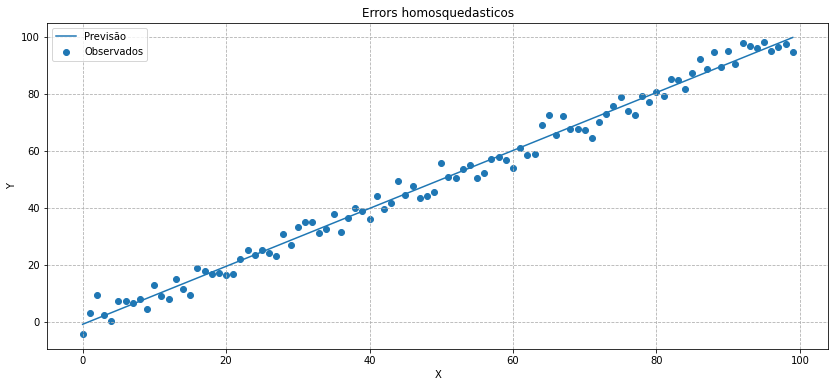

In [3]:
# Artificially create dataset with constant variance around a line
xs = np.arange(100)
y1 = xs + 3*np.random.randn(100)

# Get results of linear regression
slr1 = regression.linear_model.OLS(y1, sm.add_constant(xs)).fit()

# Construct the fit line
fit1 = slr1.params[0] + slr1.params[1]*xs

# Plot data and regression line
plt.figure(figsize=(14,6))
plt.grid(linestyle='--')
plt.scatter(xs, y1)
plt.plot(xs, fit1)
plt.title('Errors homosquedasticos');
plt.legend(['Previsão', 'Observados'])
plt.xlabel('X')
plt.ylabel('Y');

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     116.4
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.36e-18
Time:                        23:13:55   Log-Likelihood:                -490.82
No. Observations:                 100   AIC:                             985.6
Df Residuals:                      98   BIC:                             990.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9214      6.569     -1.358      0.178     -21.958       4.115
x1             1.2369      0.115     10.789      0.000       1.009       1.464
==============================================================================
Omnibus:                       12.600   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               29.321
Skew:                           0.350   Prob(JB):                     4.30e-07
Kurtosis:                       5.559   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

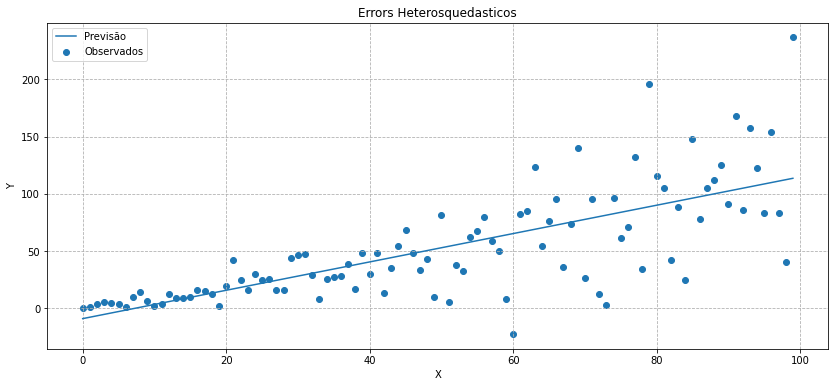

In [4]:
# Artificially create dataset with changing variance around a line
y2 = xs*(1 + .5*np.random.randn(100))

# Perform linear regression
slr2 = regression.linear_model.OLS(y2, sm.add_constant(xs)).fit()
fit2 = slr2.params[0] + slr2.params[1]*xs

# Plot data and regression line
plt.figure(figsize=(14,6))
plt.grid(linestyle='--')
plt.scatter(xs, y2)
plt.plot(xs, fit2)
plt.title('Errors Heterosquedasticos');
plt.legend(['Previsão', 'Observados'])
plt.xlabel('X')
plt.ylabel('Y')

# Print summary of regression results
slr2.summary()

### Testes para Heterosqueticidade

Você pode testar a heterocedasticidade usando alguns testes, usaremos o teste de *Breush Pagan* da biblioteca statsmodels. Também testaremos a normalidade, que neste caso também captura a não normalidade no segundo caso. No entanto, é possível ter resíduos normalmente distribuídos que também são heterocedasticos, então ambos os testes devem ser realizados para ter certeza.

In [5]:
residuals1 = y1-fit1
residuals2 = y2-fit2

xs_with_constant = sm.add_constant(xs)

_, jb_pvalue1, _, _ = statsmodels.stats.stattools.jarque_bera(residuals1)
_, jb_pvalue2, _, _ = statsmodels.stats.stattools.jarque_bera(residuals2)
print ("Valor-p para residuals1 ser normal", jb_pvalue1)
print ("Valor-p para residuals2 ser normal", jb_pvalue2)

_, pvalue1, _, _ = stats.diagnostic.het_breuschpagan(residuals1, xs_with_constant)
_, pvalue2, _, _ = stats.diagnostic.het_breuschpagan(residuals2, xs_with_constant)
print ("Valor-p para residuals1 serem heterosquedásticos", pvalue1)
print ("Valor-p para residuals2 serem heterosquedásticos", pvalue2)

Valor-p para residuals1 ser normal 0.3135448518338831
Valor-p para residuals2 ser normal 4.295441017248406e-07
Valor-p para residuals1 serem heterosquedásticos 0.7018402366877632
Valor-p para residuals2 serem heterosquedásticos 1.6017702557201423e-05


### Corrigindo a heterosquedasticidade

Como a heterocedasticidade afeta nossa análise? A situação problemática, conhecida como heterocedasticidade condicional, é quando a variância do erro está correlacionada com as variáveis independentes, como está acima. Isso faz com que o teste F para significância de regressão e t-testes para as significâncias de coeficientes individuais sejam não confiáveis. Na maioria das vezes, isso resulta em uma superestimação da significância do ajuste.

O teste Breusch-Pagan e o teste White podem ser usados para detectar heterocedasticidade condicional. Se suspeitarmos que este efeito está presente, podemos alterar nosso modelo para tentar corrigi-lo. Um método é o mínimo de quadrados generalizados, o que requer uma alteração manual da equação original. Outro é o cálculo de erros padrão robustos, que corrige as estatísticas de ajuste para explicar a heterocedasticidade. `statsmodels` pode calcular erros padrão robustos; observe a diferença nas estatísticas abaixo.

In [6]:
print(slr2.summary())
print(slr2.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     116.4
Date:                Tue, 21 Apr 2020   Prob (F-statistic):           2.36e-18
Time:                        23:13:55   Log-Likelihood:                -490.82
No. Observations:                 100   AIC:                             985.6
Df Residuals:                      98   BIC:                             990.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9214      6.569     -1.358      0.1

# Autocorrelação do erro

Um problema comum e grave é quando os erros estão correlacionados entre as observações (correlação serial ou autocorrelação). Isso pode ocorrer, por exemplo, quando alguns dos pontos de dados estão relacionados ou quando usamos dados de séries temporais com flutuações periódicas. Se uma das variáveis independentes depende dos valores anteriores da variável dependente - como, quando é igual ao valor da variável dependente no período anterior - ou se a especificação incorreta do modelo levar à autocorrelação, as estimativas dos coeficientes serão inconsistentes e portanto, inválidas. Do contrário, as estimativas dos parâmetros serão válidas, mas as estatísticas de ajuste serão imprecisas. Por exemplo, se a correlação for positiva, teremos inflação de estatísticas F e t, levando-nos a superestimar a significancia do modelo.

Se os erros são homosquedásticos, podemos testar a autocorrelação usando o teste Durbin-Watson, que é convenientemente relatado no resumo de regressão em `statsmodels`.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     5228.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        23:14:02   Log-Likelihood:                -5817.3
No. Observations:                1258   AIC:                         1.164e+04
Df Residuals:                    1256   BIC:                         1.165e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        246.8655      1.391    177.476      0.000     244.137     249.594
x1            -0.1386      0.002    -72.304      0.000      -0.142      -0.135
==============================================================================
Omnibus:                      163.610   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.150
Skew:                           0.899   Prob(JB):                     1.76e-55
Kurtosis:                       4.257   Cond. No.                     1.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

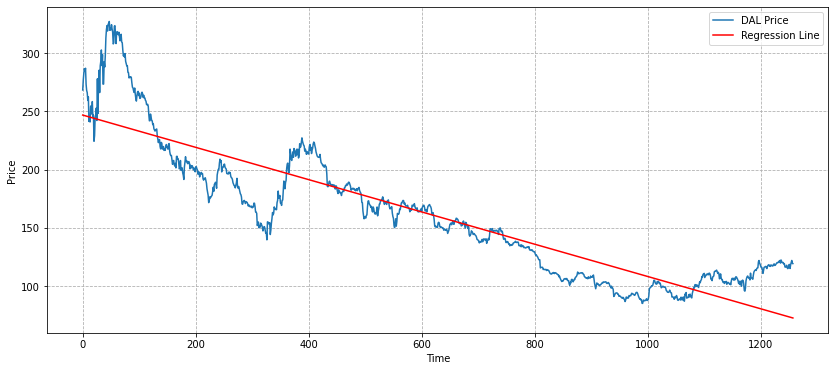

In [7]:
# Load pricing data for an asset
y = web.DataReader('AAPL', 'stooq')['Close'].apply(float).values
x = np.arange(len(y))

# Regress pricing data against time
model = regression.linear_model.OLS(y, sm.add_constant(x)).fit()

# Construct the fit line
prediction = model.params[0] + model.params[1]*x

# Plot pricing data and regression line
plt.figure(figsize=(14,6))
plt.grid(linestyle='--')
plt.plot(x,y)
plt.plot(x, prediction, color='r')
plt.legend(['DAL Price', 'Regression Line'])
plt.xlabel('Time')
plt.ylabel('Price')

# Print summary of regression results
model.summary()

### Testando Autocorrelação

Podemos testar a autocorrelação em ambos nossos preços e resíduos. Usaremos um método baseado no teste Ljun-Box. Este teste calcula a probabilidade de que o n-ésimo ponto de dados atrasado seja preditivo do atual. Se nenhum atraso máximo for dado, a função calcula um atraso máximo e retorna os valores de p para todos os atrasos até aquele. Podemos ver aqui que, para os 5 pontos de dados mais recentes, existe uma correlação significativa com a atual. Portanto, concluimos que ambos os dados são auto-correlacionados.

In [8]:
_, prices_qstats, prices_qstat_pvalues = statsmodels.tsa.stattools.acf(y, qstat=True)
_, prices_qstats, prices_qstat_pvalues = statsmodels.tsa.stattools.acf(y-prediction, qstat=True)

print ('Valor-p para autocorrelação nos preços', prices_qstat_pvalues)
print ('Valor-p para autocorrelação nos residuais', prices_qstat_pvalues)
_, jb_pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(y-prediction)

print ('Valor-p para os residuais serem normalmente distribuidos', jb_pvalue)

Valor-p para autocorrelação nos preços [1.46274628e-269 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
Valor-p para autocorrelação nos residuais [1.46274628e-269 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000

/home/tau/Projects/ds_intro/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


## Newey-West

Newey-West é um método de computar variância corrigido para autocorrelação. Uma computação de variação normal produzirá erros padrão imprecisos na presença de autocorrelação.

Podemos tentar alterar a equação de regressão para eliminar a autocorrelação. Uma solução mais simples é ajustar os erros padrão usando um método apropriado e usar os valores ajustados para verificar a significância. Abaixo, usamos o método Newey-West do `statsmodels` para calcular erros padrão ajustados para os coeficientes. Eles são mais altos do que os originalmente relatados pela regressão, que é o que esperamos para erros positivamente correlacionados.

In [9]:
from math import sqrt

# Find the covariance matrix of the coefficients
cov_mat = stats.sandwich_covariance.cov_hac(model)

# Print the standard errors of each coefficient from the original model and from the adjustment
print ('Erro padrão comum:', model.bse[0], model.bse[1])
print ('Erro padrão ajustado:', sqrt(cov_mat[0,0]), sqrt(cov_mat[1,1]))

Erro padrão comum: 1.3909836186422229 0.0019162890018813341
Erro padrão ajustado: 5.475155593455232 0.007097938275482932


# Multicollinearidade

Ao usar múltiplas variáveis independentes, é importante verificar a multicolinearidade; ou seja, uma relação linear aproximada entre as variáveis independentes, como, por exemplo
$$ X_2 \approx 5 X_1 - X_3 + 4.5 $$
Com a multicolinearidade, é difícil identificar o efeito independente de cada variável, pois podemos mudar em torno dos coeficientes de acordo com a relação linear sem alterar o modelo. Tal como acontece com variáveis verdadeiramente desnecessárias, isso geralmente não prejudicará a precisão do modelo, mas irá nublar nossa análise. Em particular, os coeficientes estimados terão grandes erros padrão. Os coeficientes também não representam mais o efeito parcial de cada variável, pois com a multicolinearidade não podemos mudar uma variável enquanto mantendo as outras constantes.

A alta correlação entre variáveis independentes é indicativa de multicolinearidade. No entanto, não é suficiente, uma vez que queremos detectar a correlação entre uma das variáveis e uma combinação linear das outras variáveis. Se tivermos estatísticas R-quadrados altas, mas baixas estatísticas-t nos coeficientes (o ajuste é bom, mas os coeficientes não são estimados com precisão) podemos suspeitar de multicolinearidade. Para resolver o problema, podemos retirar uma das variáveis independentes envolvidas na relação linear.

Por exemplo, usando dois índices de estoque, como nossas variáveis independentes, provavelmente levarão a multicolinearidade. Abaixo, podemos ver que a remoção de um deles melhora as estatísticas-t sem prejudicar o R-quadrado.

Outra coisa importante a determinar aqui é qual variável pode ser a casual. Se formularmos a hipótese de que o mercado influencie AAPL e AMZN, o mercado é a variável que devemos usar em nosso modelo preditivo.

R-quadrado: 0.8885292236579279
estatística-t dos coeficientes:
 [-35.60330794  34.69741832   1.73656382]


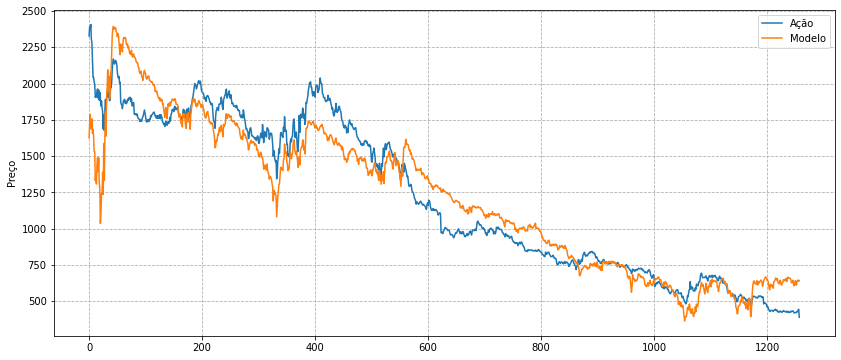

In [10]:
# Load pricing data for asset and two market indices
symbols = [
    'AAPL', # apple
    'AMZN', # amazon
    'SPY' # S&P500
]

stocks = {}
for symbol in symbols:
    stocks[symbol] = web.DataReader(symbol, 'stooq')['Close'].apply(float).values

# Run multiple linear regression
mlr = regression.linear_model.OLS(stocks['AMZN'], sm.add_constant(np.column_stack((stocks['SPY'], stocks['AAPL'])))).fit()

# Construct fit curve using dependent variables and estimated coefficients
mlr_prediction = mlr.params[0] + mlr.params[1]*stocks['SPY'] + mlr.params[2]*stocks['AAPL']

# Print regression statistics 
print('R-quadrado:', mlr.rsquared_adj)
print('estatística-t dos coeficientes:\n', mlr.tvalues)

# Plot asset and model
plt.figure(figsize=(14,6))
plt.grid(linestyle='--')
plt.plot(stocks['AMZN'])
plt.plot(mlr_prediction)
plt.legend(['Ação', 'Modelo']);
plt.ylabel('Preço');

R-quadrado: 0.8883503331280445
estatística-t dos coeficientes:
 [-56.94696845 100.0121511 ]


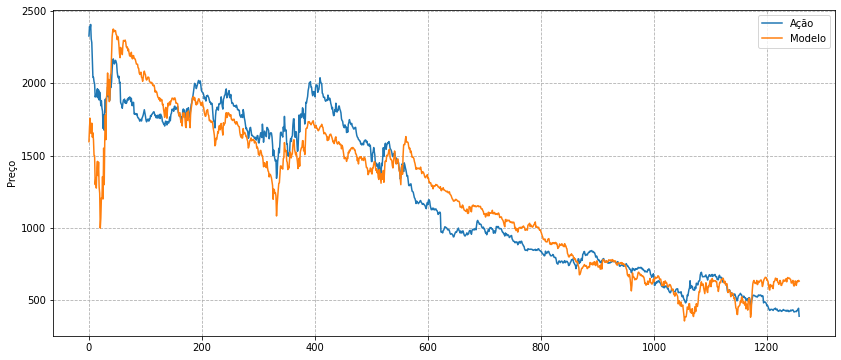

In [11]:
# Perform linear regression
slr = regression.linear_model.OLS(stocks['AMZN'], sm.add_constant(stocks['SPY'])).fit()
slr_prediction = slr.params[0] + slr.params[1] * stocks['SPY']

# Print fit statistics
print('R-quadrado:', slr.rsquared_adj)
print('estatística-t dos coeficientes:\n', slr.tvalues)

# Plot asset and model
plt.figure(figsize=(14,6))
plt.grid(linestyle='--')
plt.plot(stocks['AMZN'])
plt.plot(slr_prediction)
plt.legend(['Ação', 'Modelo']);
plt.ylabel('Preço');

# Exemplo: quarteto de Anscombe

Anscombe construiu 4 conjuntos de dados que não só têm a mesma média e variância em cada variável, mas também o mesmo coeficiente de correlação, linha de regressão e valor de regressão R-quadrado. Abaixo, nós testamos esse resultado bem como planejamos os conjuntos de dados. Uma rápida olhada nos gráficos mostra que apenas o primeiro conjunto de dados satisfaz os pressupostos do modelo de regressão. Conseqüentemente, os altos valores de R-quadrados dos outros três não são significativos, o que concorda com a nossa intuição de que os outros três não são modelados de acordo com as linhas de melhor ajuste.

Cofficients: [3.00009091 0.50009091] [3.00090909 0.5       ] [3.00245455 0.49972727] [3.00172727 0.49990909]
Pearson r: 0.81642051634484 0.8162365060002427 0.8162867394895982 0.8165214368885029
R-squared: 0.6665424595087751 0.6662420337274844 0.6663240410665592 0.6667072568984653


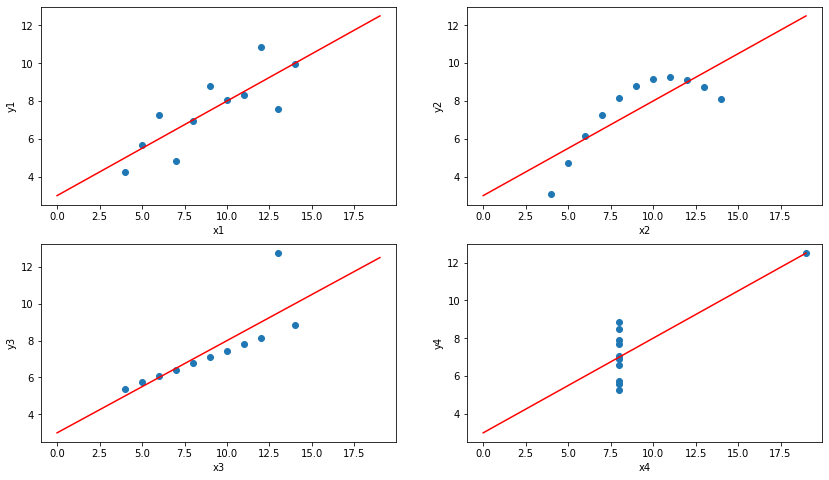

In [12]:
from scipy.stats import pearsonr

# Construct Anscombe's arrays
x1 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
x2 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
x3 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

# Perform linear regressions on the datasets
slr1 = regression.linear_model.OLS(y1, sm.add_constant(x1)).fit()
slr2 = regression.linear_model.OLS(y2, sm.add_constant(x2)).fit()
slr3 = regression.linear_model.OLS(y3, sm.add_constant(x3)).fit()
slr4 = regression.linear_model.OLS(y4, sm.add_constant(x4)).fit()

# Print regression coefficients, Pearson r, and R-squared for the 4 datasets
print('Cofficients:', slr1.params, slr2.params, slr3.params, slr4.params)
print('Pearson r:', pearsonr(x1, y1)[0], pearsonr(x2, y2)[0], pearsonr(x3, y3)[0], pearsonr(x4, y4)[0])
print('R-squared:', slr1.rsquared, slr2.rsquared, slr3.rsquared, slr4.rsquared)

# Plot the 4 datasets with their regression lines
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,8))
xs = np.arange(20)
ax1.plot(slr1.params[0] + slr1.params[1]*xs, 'r')
ax1.scatter(x1, y1)
ax1.set_xlabel('x1')
ax1.set_ylabel('y1')
ax2.plot(slr2.params[0] + slr2.params[1]*xs, 'r')
ax2.scatter(x2, y2)
ax2.set_xlabel('x2')
ax2.set_ylabel('y2')
ax3.plot(slr3.params[0] + slr3.params[1]*xs, 'r')
ax3.scatter(x3, y3)
ax3.set_xlabel('x3')
ax3.set_ylabel('y3')
ax4.plot(slr4.params[0] + slr4.params[1]*xs, 'r')
ax4.scatter(x4,y4)
ax4.set_xlabel('x4')
ax4.set_ylabel('y4');

### References
* "Quantitative Investment Analysis", by DeFusco, McLeavey, Pinto, and Runkle
* https://www.quantopian.com/lectures/violations-of-regression-models

[Retornar para o sumário](./index.html)